### Pre-requisites:

In [1]:
#Libraries for time computation and data importation:
import time
import os

#Libraries to manage the Interaction Matrix:
import pandas as pd
import numpy as np

#Library to evaluate the correct number of factors:
import matplotlib
from matplotlib import pyplot as plt

### Algorithms:

In [2]:
#Non-negative Factorization of the Interaction Matrix:
def factorization(data, n_factors, steps = 200, alpha = 0.0002, beta = 0.02):
    """
    FUNCTION:
    Standard non-negative factorization of the Interaction Matrix using the method of the Gradient descend.
    
    PARAMETERS:
    data -> Pandas Dataframe with the user-item Interaction Matrix.
    n_factors -> Number of factors for the factorization.
    steps -> Maximum number of iterations admitted for the Gradient descend algorithm.
    alpha -> Learning Rate.
    beta -> Parameter for regularization.
    
    RETURNS:
    U -> Numpy array with the (n_user x n_factor) matrix.
    I -> Numpy array with the (n_factors x n_items) matrix.
    E -> Error in the approximation of the Interaction Matrix.
    """
    #Dimensions of the Interaction Matrix
    n = data.shape[0]
    m = data.shape[1]
    
    #Convert the Matrix in a Numpy Array
    data = np.array(data)
    
    #Inizialize randomly the matrices for the factorization
    U = np.random.rand(n, n_factors)
    I = np.random.rand(n_factors, m)
    
    #Repeat the algorithm for a maximum number of iterations
    for iteration in range(steps):
        
        #Loop through all the entries of the Interaction Matrix
        for user in range(n):
            for item in range(m):
                
                #check if the item has been rated
                if data[user][item] > 0:
                    
                    #Compute the squared error in the approximation
                    eij = data[user][item] - np.dot(U[user, :], I[:, item])
                    
                    #Update the entries of the matrices for the factorization
                    for factor in range(n_factors):
                        U[user][factor] = U[user][factor] + 2*alpha*(eij * I[factor][item] - beta * U[user][factor])
                        I[factor][item] = I[factor][item] + 2*alpha*(eij * U[user][factor] - beta * I[factor][item])
        
        #Compute the error in the overall approximation of the Interaction Matrix
        E = 0
        for user in range(n):
            for item in range(m):
                if data[user][item] > 0:
                    E = E + (data[user][item] - np.dot(U[user, :], I[:, item]))**2
                    
                    #Add a regularization term
                    for factor in range(n_factors):
                        E = E + (beta/2) * ((U[user][factor])**2 + (I[factor][item])**2)
        
        #Check if the approximation is acceptable
        if E < 0.001:
            break
            
    return (U, I, E)

def suggest(data, factorized, target):
    """
    FUNCTION:
    Returns the suggestions for the unseen items of the target user.
    
    PARAMETERS:
    data -> Pandas Dataframe with the user-item Interaction Matrix.
    target -> Target user.
    factorized -> Pandas Dataframe containing the cross product between the matrices "U" and "I".
        
    RETURNS:
    Dictionary containing the suggestions for the target user based on the Matrix factorization.
    """    
    #Items not rated by the target user
    unseen = data.iloc[target][np.isnan(data.iloc[target])].index
    
    #Dictionary to store items according to their class of recommendation
    recommandations = {
    "Strongly Recommended" : list(),
    "Recommended" : list(),
    "Not Recommended" : list()
    }
    
    #For each item already not rated
    for item in unseen:
        
        #Extract the predicted rating
        rating = factorized.iloc[target][item]
        
        #Rule defined for the recommendation class assignment
        if rating >= 4:
            recommandations["Strongly Recommended"].append(item)
        elif rating >= 3:
            recommandations["Recommended"].append(item)
        else:
            recommandations["Not Recommended"].append(item)

    return recommandations

def recommend(data, target, n_factors, steps = 200, alpha = 0.0002, beta = 0.02, to_train = True):
    """
    FUNCTION:
    Perform in a single command all the previous algorithms necessary to obtain the recommendation.
    
    PARAMETERS:
    data -> Pandas Dataframe with the user-item Interaction Matrix.
    target -> Target user.
    n_factors -> Number of factors for the factorization.
    steps -> Maximum number of iterations admitted for the Gradient descend algorithm.
    alpha -> Learning Rate.
    beta -> Parameter for regularization.
    to_train -> Boolean value which specifies if the Factorization has to be performed or not (set equal to True only the first
    time)
    
    RETURNS:
    Dictionary containing the suggestions for the target user based on the Matrix factorization.
    """
    if to_train:
        U, I, E = factorization(data, n_factors, steps = steps, alpha = alpha, beta = beta)
        temporary = np.dot(U, I)
        factorized = pd.DataFrame(temporary, columns = data.columns)

    return suggest(data, factorized, target)

### Test on real data:

In [3]:
#Data importation:
path = os.path.join(os.getcwd(), "data_s.csv")
df = pd.read_csv(path)
df

,Toy Story,Twelve Monkeys,Se7en,The Usual Suspects,Braveheart,Apollo 13,Star Wars,Pulp Fiction,The Shawshank Redemption,Forrest Gump,...,Independence Day,The Godfather,The Empire Strikes Back,Raiders of the Lost Ark,Return of the Jedi,Back to the Future,The Matrix,American Beauty,Fight Club,The Lord of the Rings: The Fellowship of the Ring
0,NaN,NaN,4.0,4.0,4.0,5.0,NaN,4.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.5,5.0,5.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,4.0,5.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,5.0,...,NaN,5.0,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,4.0,...,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,5.0,NaN,5.0,NaN,5.0,3.0,...,3.0,NaN,5.0,5.0,5.0,3.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,NaN,4.0,NaN,NaN,NaN,NaN,4.0,4.0,5.0,4.0,...,NaN,NaN,4.0,NaN,4.0,5.0,5.0,3.0,5.0,5.0
485,NaN,NaN,NaN,NaN,2.0,4.0,NaN,4.0,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
486,NaN,5.0,NaN,NaN,4.0,4.0,NaN,5.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
487,4.0,3.0,5.0,5.0,3.0,3.0,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN


In [8]:
#Select the number of factors factors with personal factorization considering a default step = 200:
for factors in range(5, 20):
    print("Factors: " + str(factors))
    print(factorization(df, n_factors = factors)[2])
    print("-"*125)

current = int(time.ctime().split()[3].split(":")[0])*60*60 + int(time.ctime().split()[3].split(":")[1])*60 + int(time.ctime().split()[3].split(":")[2])

Factors: 5
4470.688759148155
-----------------------------------------------------------------------------------------------------------------------------
Factors: 6
4403.316109698259
-----------------------------------------------------------------------------------------------------------------------------
Factors: 7
4328.660306305452
-----------------------------------------------------------------------------------------------------------------------------
Factors: 8
4274.318159243639
-----------------------------------------------------------------------------------------------------------------------------
Factors: 9
4295.622142254866
-----------------------------------------------------------------------------------------------------------------------------
Factors: 10
4223.506065182914
-----------------------------------------------------------------------------------------------------------------------------
Factors: 11
4193.51593319426
----------------------------------------

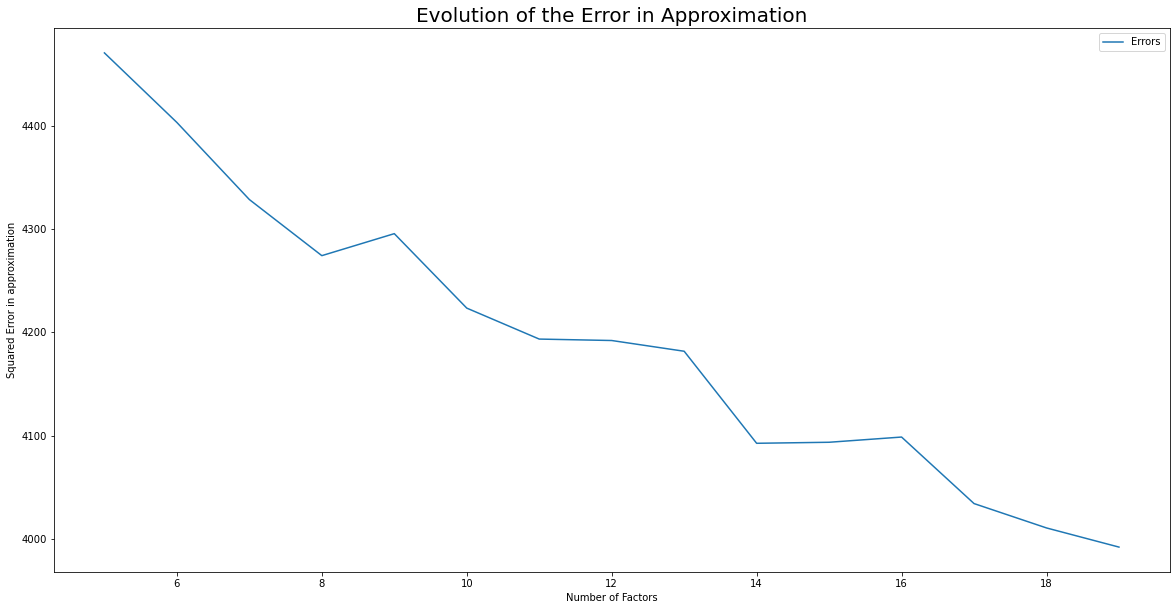

In [11]:
#Plot the error's evolution:
errors = [4470.688759148155, 4403.316109698259, 4328.660306305452, 4274.318159243639, 4295.622142254866, 4223.506065182914,
         4193.51593319426, 4192.125214043815, 4181.7272927489485, 4092.578242283392, 4093.5723302169717, 4098.621219550327,
         4034.191187832277, 4010.5854810436585, 3992.03658537703]
factors = [k for k in range(5, 20)]
summary = pd.DataFrame(errors, columns = ["Errors"])
summary["factors"] = factors
summary.set_index("factors", inplace = True)
summary.plot(figsize = (20, 10), xlabel = "Number of Factors", ylabel = "Squared Error in approximation") #We choose 14
plt.title("Evolution of the Error in Approximation", fontsize = 20)
plt.show()

In [4]:
#Factorize the Interaction Matrix with the chosen number of factors to find the best value of "step":
for step in (200, 500, 1000):
    start_time = int(time.ctime().split()[3].split(":")[0])*60*60 + int(time.ctime().split()[3].split(":")[1])*60 + int(time.ctime().split()[3].split(":")[2])

    E = factorization(df, n_factors = 14, steps = step)[2]

    current = int(time.ctime().split()[3].split(":")[0])*60*60 + int(time.ctime().split()[3].split(":")[1])*60 + int(time.ctime().split()[3].split(":")[2])
    print("Steps: " + str(step))
    print("\nTotal time required: " + str(current - start_time) + "s")
    print("E = " + str(E))
    print("-"*125)

Steps: 200

Total time required: 245s
E = 4170.774250741257
-----------------------------------------------------------------------------------------------------------------------------
Steps: 500

Total time required: 613s
E = 3432.456657826487
-----------------------------------------------------------------------------------------------------------------------------
Steps: 1000

Total time required: 1216s
E = 2242.228933797726
-----------------------------------------------------------------------------------------------------------------------------


In [5]:
#Attempt with steps = 2000:
start_time = int(time.ctime().split()[3].split(":")[0])*60*60 + int(time.ctime().split()[3].split(":")[1])*60 + int(time.ctime().split()[3].split(":")[2])

U, I, E = factorization(df, n_factors = 14, steps = 2000)

current = int(time.ctime().split()[3].split(":")[0])*60*60 + int(time.ctime().split()[3].split(":")[1])*60 + int(time.ctime().split()[3].split(":")[2])
print("\nTotal time required: " + str(current - start_time) + "s")
print("E = " + str(E))


Total time required: 2380s
E = 1608.5616013733422


In [6]:
#Attempt with steps = 3000:
start_time = int(time.ctime().split()[3].split(":")[0])*60*60 + int(time.ctime().split()[3].split(":")[1])*60 + int(time.ctime().split()[3].split(":")[2])

E = factorization(df, n_factors = 14, steps = 3000)[2]

current = int(time.ctime().split()[3].split(":")[0])*60*60 + int(time.ctime().split()[3].split(":")[1])*60 + int(time.ctime().split()[3].split(":")[2])
print("\nTotal time required: " + str(current - start_time) + "s")
print("E = " + str(E))


Total time required: 3516s
E = 1423.44855101308


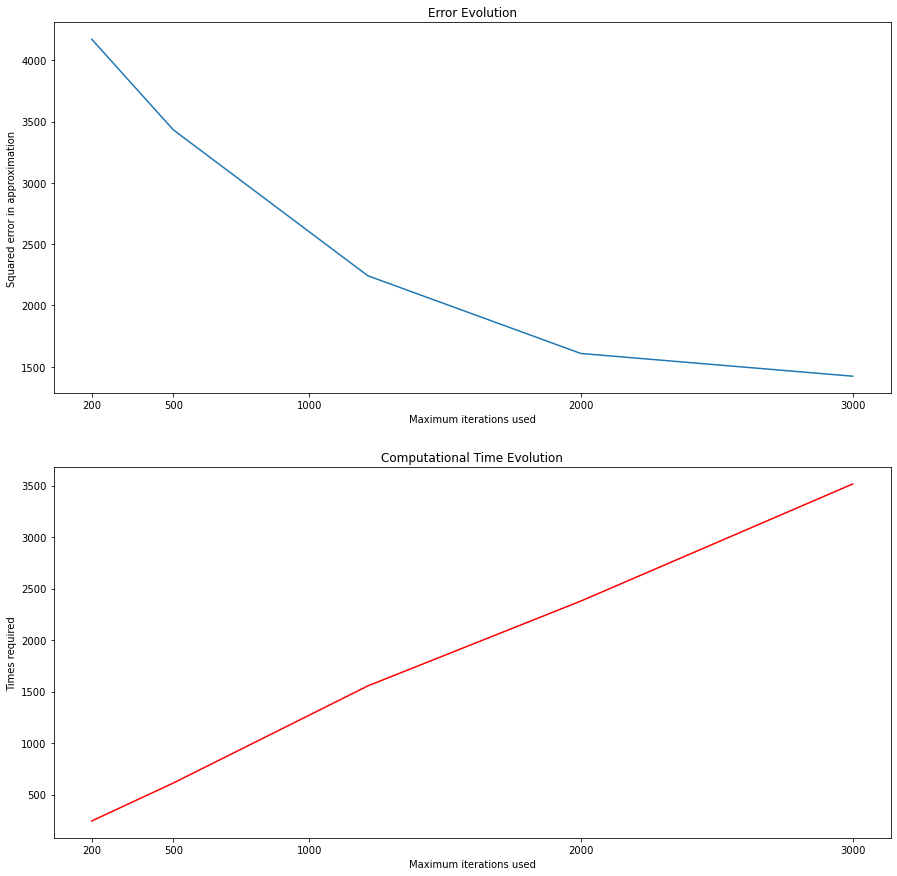

In [10]:
#Graphical summary:
figure, axes = plt.subplots(nrows = 2)
figure.set_figheight(15)
figure.set_figwidth(15)

errors = (4170.774250741257, 3432.456657826487, 2242.228933797726, 1608.5616013733422, 1423.44855101308)
steps = (200, 500, 1216, 2000, 3000)
axes[0].plot(steps, errors)
axes[0].set_title("Error Evolution")
axes[0].set_xlabel("Maximum iterations used")
axes[0].set_xticks((200, 500, 1000, 2000, 3000))
axes[0].set_ylabel("Squared error in approximation")

times = (245, 613, 1556, 2380, 3516)
axes[1].plot(steps, times, color = "red")
axes[1].set_title("Computational Time Evolution")
axes[1].set_xlabel("Maximum iterations used")
axes[1].set_xticks((200, 500, 1000, 2000, 3000))
axes[1].set_ylabel("Times required")

plt.show()

In [7]:
#Build the approximized matrix:
temporary = np.dot(U, I)
factorized = pd.DataFrame(temporary, columns = df.columns)

In [8]:
#Test the algorithms on one user:
print("Suggestions for user: " + str(3))
suggest(df, factorized, 3)

Suggestions for user: 3


{'Strongly Recommended': ['Toy Story',
  'Independence Day',
  'Back to the Future'],
 'Recommended': ['Twelve Monkeys',
  'Se7en',
  'The Usual Suspects',
  'Braveheart',
  'Star Wars',
  'The Shawshank Redemption',
  'True Lies',
  'The Fugitive',
  'Jurassic Park',
  "Schindler's List",
  'Terminator 2: Judgment Day',
  'Batman',
  'The Empire Strikes Back',
  'Raiders of the Lost Ark',
  'Return of the Jedi',
  'The Matrix',
  'Fight Club'],
 'Not Recommended': ['Pulp Fiction',
  'Dances with Wolves',
  'The Silence of the Lambs',
  'Fargo',
  'American Beauty',
  'The Lord of the Rings: The Fellowship of the Ring']}

In [9]:
#Test the algorithms for all the users:
start_time = int(time.ctime().split()[3].split(":")[0])*60*60 + int(time.ctime().split()[3].split(":")[1])*60 + int(time.ctime().split()[3].split(":")[2])

for target in df.index:
    print("Suggestions for user :" + str(target))
    print(suggest(df, factorized, target))
    print("-"*125)

current = int(time.ctime().split()[3].split(":")[0])*60*60 + int(time.ctime().split()[3].split(":")[1])*60 + int(time.ctime().split()[3].split(":")[2])
print("\nTotal time required: " + str(current - start_time) + "s")

Suggestions for user :0
{'Strongly Recommended': ['Twelve Monkeys', 'Star Wars', 'The Shawshank Redemption', 'The Godfather', 'The Empire Strikes Back', 'Return of the Jedi', 'Back to the Future', 'American Beauty', 'Fight Club'], 'Recommended': ['Toy Story', 'True Lies', 'Fargo', 'Independence Day', 'Raiders of the Lost Ark', 'The Matrix', 'The Lord of the Rings: The Fellowship of the Ring'], 'Not Recommended': []}
-----------------------------------------------------------------------------------------------------------------------------
Suggestions for user :1
{'Strongly Recommended': ['Twelve Monkeys', 'Apollo 13', 'The Fugitive', 'Terminator 2: Judgment Day', 'Fargo', 'Independence Day', 'The Godfather', 'Raiders of the Lost Ark', 'Back to the Future', 'The Matrix'], 'Recommended': ['Toy Story', 'Se7en', 'The Usual Suspects', 'Star Wars', 'True Lies', 'Jurassic Park', 'Dances with Wolves', 'The Empire Strikes Back', 'The Lord of the Rings: The Fellowship of the Ring'], 'Not Recomm

{'Strongly Recommended': ['Star Wars', 'Pulp Fiction', 'The Lion King', 'The Godfather', 'Raiders of the Lost Ark', 'The Lord of the Rings: The Fellowship of the Ring'], 'Recommended': ['Toy Story', 'Twelve Monkeys', 'Se7en', 'The Usual Suspects', 'Apollo 13', 'Forrest Gump', 'True Lies', 'The Fugitive', "Schindler's List", 'Aladdin', 'Dances with Wolves', 'Batman', 'The Silence of the Lambs', 'Fargo', 'Independence Day', 'American Beauty', 'Fight Club'], 'Not Recommended': []}
-----------------------------------------------------------------------------------------------------------------------------
Suggestions for user :99
{'Strongly Recommended': ['Se7en', 'The Usual Suspects', 'The Fugitive', "Schindler's List", 'Fargo', 'Independence Day'], 'Recommended': ['Toy Story', 'Twelve Monkeys', 'Braveheart', 'Apollo 13', 'Star Wars', 'Pulp Fiction', 'The Lion King', 'True Lies', 'Aladdin', 'Terminator 2: Judgment Day', 'Dances with Wolves', 'Batman', 'The Silence of the Lambs', 'The Godf

{'Strongly Recommended': ['Toy Story', 'Se7en', 'The Usual Suspects', 'Apollo 13', 'The Shawshank Redemption', "Schindler's List", 'Aladdin', 'The Silence of the Lambs', 'Fargo', 'The Godfather', 'Raiders of the Lost Ark', 'American Beauty'], 'Recommended': ['Twelve Monkeys', 'The Lion King', 'True Lies', 'The Fugitive', 'Jurassic Park', 'Batman', 'Independence Day'], 'Not Recommended': ['Dances with Wolves']}
-----------------------------------------------------------------------------------------------------------------------------
Suggestions for user :180
{'Strongly Recommended': ['The Usual Suspects', 'True Lies', 'Terminator 2: Judgment Day', 'The Silence of the Lambs', 'The Empire Strikes Back', 'Raiders of the Lost Ark', 'The Matrix', 'Fight Club', 'The Lord of the Rings: The Fellowship of the Ring'], 'Recommended': ['Se7en', 'Braveheart', 'Apollo 13', 'Pulp Fiction', 'The Shawshank Redemption', 'Forrest Gump', 'The Lion King', 'The Fugitive', 'Jurassic Park', "Schindler's List

{'Strongly Recommended': ['Toy Story', 'Twelve Monkeys', 'Apollo 13', 'Star Wars', 'The Shawshank Redemption', 'Forrest Gump', 'The Lion King', "Schindler's List", 'Terminator 2: Judgment Day', 'The Godfather', 'The Empire Strikes Back', 'Raiders of the Lost Ark', 'Return of the Jedi', 'Back to the Future', 'American Beauty', 'Fight Club', 'The Lord of the Rings: The Fellowship of the Ring'], 'Recommended': ['Braveheart', 'Pulp Fiction', 'True Lies', 'Jurassic Park', 'Aladdin', 'Dances with Wolves', 'Batman', 'Independence Day'], 'Not Recommended': []}
-----------------------------------------------------------------------------------------------------------------------------
Suggestions for user :260
{'Strongly Recommended': ['Se7en', 'Braveheart', 'Pulp Fiction', 'The Lion King', 'True Lies', 'Aladdin', 'Terminator 2: Judgment Day', 'The Empire Strikes Back', 'Raiders of the Lost Ark', 'Back to the Future', 'The Matrix', 'Fight Club', 'The Lord of the Rings: The Fellowship of the Rin

{'Strongly Recommended': [], 'Recommended': ['Dances with Wolves', 'Independence Day'], 'Not Recommended': ['Braveheart', 'Batman']}
-----------------------------------------------------------------------------------------------------------------------------
Suggestions for user :343
{'Strongly Recommended': ['Toy Story', 'Twelve Monkeys', 'Se7en', 'The Usual Suspects', 'Apollo 13', 'Star Wars', 'Pulp Fiction', 'The Shawshank Redemption', 'The Fugitive', 'Jurassic Park', "Schindler's List", 'Aladdin', 'Terminator 2: Judgment Day', 'Dances with Wolves', 'Batman', 'The Silence of the Lambs', 'Fargo', 'The Godfather', 'The Empire Strikes Back', 'Raiders of the Lost Ark', 'Return of the Jedi', 'Back to the Future', 'American Beauty', 'The Lord of the Rings: The Fellowship of the Ring'], 'Recommended': ['True Lies'], 'Not Recommended': []}
-----------------------------------------------------------------------------------------------------------------------------
Suggestions for user :344
{

{'Strongly Recommended': ['Star Wars', 'Aladdin', 'Fargo', 'The Godfather', 'The Empire Strikes Back', 'Raiders of the Lost Ark', 'Return of the Jedi', 'Back to the Future', 'The Matrix', 'American Beauty', 'Fight Club', 'The Lord of the Rings: The Fellowship of the Ring'], 'Recommended': ['Toy Story'], 'Not Recommended': ['Independence Day']}
-----------------------------------------------------------------------------------------------------------------------------
Suggestions for user :431
{'Strongly Recommended': ['Toy Story', 'The Usual Suspects', 'The Shawshank Redemption', 'The Lion King', 'Raiders of the Lost Ark', 'Back to the Future', 'The Matrix', 'The Lord of the Rings: The Fellowship of the Ring'], 'Recommended': ['Twelve Monkeys', 'Star Wars', 'Forrest Gump', "Schindler's List", 'Fargo', 'The Godfather', 'The Empire Strikes Back', 'Return of the Jedi', 'American Beauty', 'Fight Club'], 'Not Recommended': []}
----------------------------------------------------------------